In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import os

In [2]:
nsims = 100
nside = 256
npix = hp.nside2npix(nside)
lmax = 3*nside-1

In [3]:
mask = hp.read_map(f"data/mask_apodized_ns{nside}.fits")

In [4]:
maskb = (mask > 0).astype(float)

In [5]:
f = nmt.NmtField(mask, None, spin=2, purify_b=True)
b = nmt.NmtBin.from_nside_linear(nside, nlb=10)
w = nmt.NmtWorkspace.from_fields(f, f, b)
leff = b.get_effective_ells()

In [6]:
os.system('mkdir -p data/cls')
cls = []
pcls = []
clins = []
for i in range(nsims):
    seed = 1000 + i
    fname = f'data/cls/cls_cmb_{seed}.npz'
    if os.path.isfile(fname):
        d = np.load(fname)
        cl = d['cl']
        pcl = d['pcl']
        clin = d['clin']
    else:
        print(seed)
        q, u = hp.read_map(f'data/sims/sim_cmb_{seed}.fits', field=None)
        _, clee, clbb, _, cleb, _ = hp.anafast(np.array([0*q, q, u]))
        f = nmt.NmtField(mask, [q*maskb, u*maskb], purify_b=True)
        pcl = nmt.compute_coupled_cell(f, f)
        cl = w.decouple_cell(pcl)
        clin = np.array([clee, cleb, cleb, clbb])
        cl = cl
        pcl = pcl
        np.savez(fname, cl=cl, pcl=pcl, clin=clin)
    cls.append(cl)
    pcls.append(pcl)
    clins.append(clin)
cls = np.array(cls)
pcls = np.array(pcls)
clins = np.array(clins)

In [7]:
def read_cls():
    ls = np.arange(lmax+1)
    ll, dltt, dlee, dlbb, dlte = np.loadtxt("data/camb_lens_nobb.dat", unpack=True)
    dl2cl = 2*np.pi/(ll*(ll+1))
    cltt = np.zeros(lmax+1); cltt[2:] = (dl2cl*dltt)[1:lmax]
    clee = np.zeros(lmax+1); clee[2:] = (dl2cl*dlee)[1:lmax]
    clbb = np.zeros(lmax+1); clbb[2:] = (dl2cl*dlbb)[1:lmax]
    clte = np.zeros(lmax+1); clte[2:] = (dl2cl*dlte)[1:lmax]
    return ls, cltt, clee, clbb, clte


ls, cltt, clee, clbb, clte = read_cls()
cl_pred_full = np.array([clee, 0*clee, 0*clee, clbb])
cl_pred = w.decouple_cell(w.couple_cell(cl_pred_full))

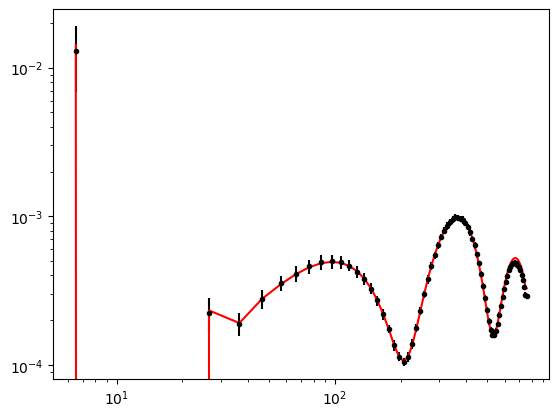

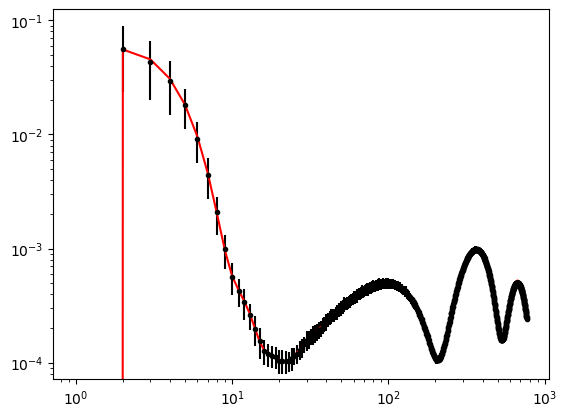

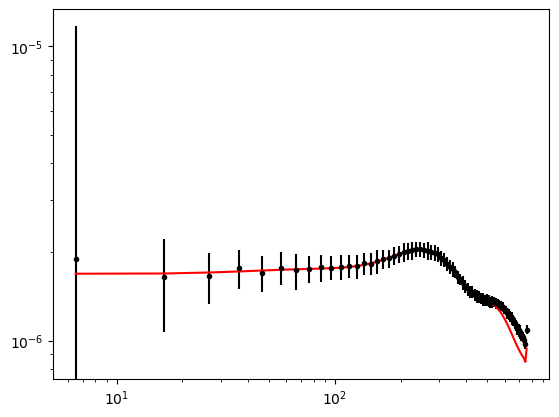

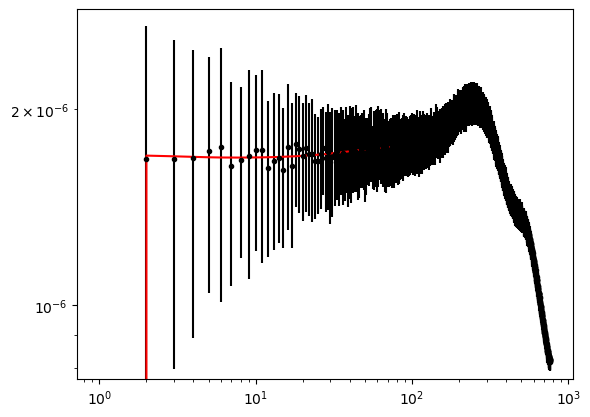

In [8]:
for icl in [0, 3]:
    # Masked
    plt.figure()
    plt.errorbar(leff, np.mean(cls[:, icl, :], axis=0),
                 yerr=np.std(cls[:, icl, :], axis=0), fmt='k.')
    plt.plot(leff, cl_pred[icl], 'r-')
    plt.loglog()
    
    # Full-sky
    plt.figure()
    plt.errorbar(ls, np.mean(clins[:, icl, :], axis=0),
                 yerr=np.std(clins[:, icl, :], axis=0), fmt='k.')
    plt.plot(ls, cl_pred_full[icl], 'r-')
    plt.loglog()
    plt.loglog()

In [9]:
n_ell = len(leff)
f = nmt.NmtField(mask, None, spin=2)
cls_4cov = w.couple_cell(cl_pred_full)/np.mean(mask**2)
cw = nmt.NmtCovarianceWorkspace.from_fields(f, f)

f = nmt.NmtField(mask, None, spin=0)
w_sp0 = nmt.NmtWorkspace.from_fields(f, f, b)
cw_sp0 = nmt.NmtCovarianceWorkspace.from_fields(f, f, spin0_only=True)
cl_ee_4cov = w_sp0.couple_cell([cl_pred_full[0]])/np.mean(mask**2)
cl_bb_4cov = w_sp0.couple_cell([cl_pred_full[-1]])/np.mean(mask**2)

cov_sp2 = nmt.gaussian_covariance(cw, 2, 2, 2, 2,
                                  cls_4cov, cls_4cov,
                                  cls_4cov, cls_4cov,
                                  w).reshape([n_ell, 4, n_ell, 4])
cov_ee_sp0 = nmt.gaussian_covariance(cw_sp0, 0, 0, 0, 0,
                                     cl_ee_4cov, cl_ee_4cov,
                                     cl_ee_4cov, cl_ee_4cov,
                                     w_sp0)
cov_bb_sp0 = nmt.gaussian_covariance(cw_sp0, 0, 0, 0, 0,
                                     cl_bb_4cov, cl_bb_4cov,
                                     cl_bb_4cov, cl_bb_4cov,
                                     w_sp0)

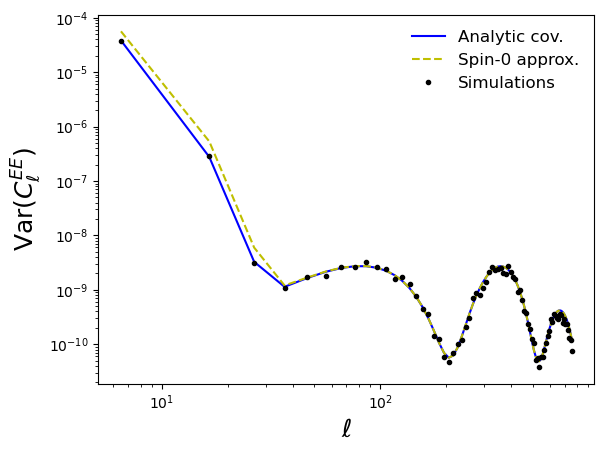

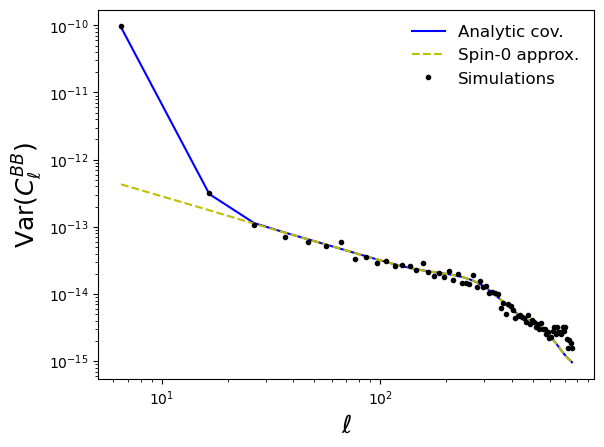

In [10]:
plt.figure()
plt.plot(leff, np.diag(cov_sp2[:, 0, :, 0]), 'b-', label='Analytic cov.')
plt.plot(leff, np.diag(cov_ee_sp0), 'y--', label='Spin-0 approx.')
plt.plot(leff, np.std(cls[:, 0, :], axis=0)**2, 'k.', label='Simulations')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=18)
plt.ylabel(r'${\rm Var}(C^{EE}_\ell)$', fontsize=18)
plt.legend(frameon=False, fontsize=12)

plt.figure()
plt.plot(leff, np.diag(cov_sp2[:, 3, :, 3]), 'b-', label='Analytic cov.')
plt.plot(leff, np.diag(cov_bb_sp0), 'y--', label='Spin-0 approx.')
plt.plot(leff, np.std(cls[:, 3, :], axis=0)**2, 'k.', label='Simulations')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=18)
plt.ylabel(r'${\rm Var}(C^{BB}_\ell)$', fontsize=18)
plt.legend(frameon=False, fontsize=12)

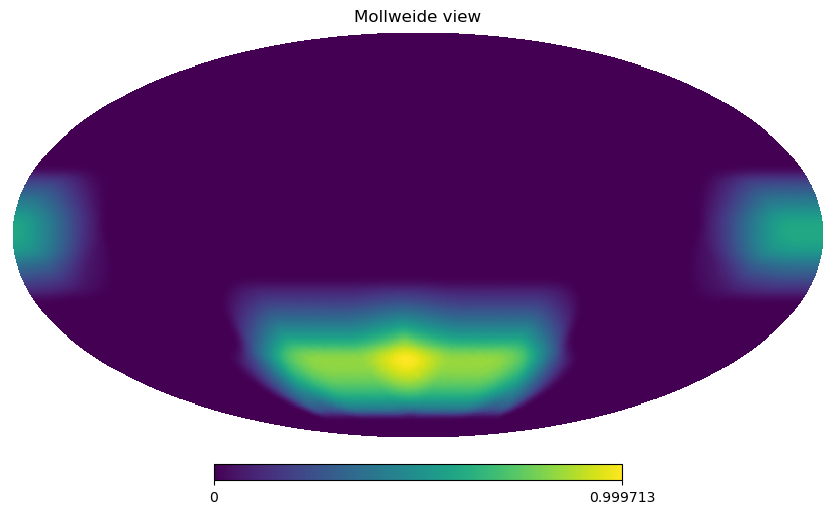

In [11]:
hp.mollview(mask)